# PARTIE 3 : Transfer learning

Dans cette partie nous utilisons le célèbre algorithme BERT de Google pour notre problématique.

Ce modèle de traitement du langage naturel a été pré-entraîné sur de grands ensembles de donneés textuelles.

Il convient particulièrement pour la détection de spam.

Nous suivons la documentation de TensorFlow pour mettre en place le modèle BERT : [TensorFlow Resource]('https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=fr#loading_models_from_tensorflow_hub').




## Import des données

In [45]:
import pandas as pd
df = pd.read_csv('messages.csv')

In [46]:
df.head()

,label,message
0,0,jurong point crazy available bugis n great wor...
1,0,ok lar joke wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun early hor u c
4,0,nah think usf live


In [47]:
df.shape

(5555, 2)

## Preprocessings

### Distinguer les variables

In [48]:
X = df['message'].values
y = df['label'].values

### Diviser le jeu de données en train set et set de validation

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

In [50]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

### Création d'un train batch et d'un validation batch

In [51]:
train_batch = train.shuffle(len(train)).batch(32)
val_batch = val.shuffle(len(val)).batch(32)

## Import librairies

In [ ]:
!pip3 install keras==2.1.6

Tensorflow-text est une librairie open-source développée par Google pour Tensorflow. Elle permet d'appliquer les différents preprocessings nécessaires sur le texte : --> tokeniser, transformer en vecteur, normaliser, supprimer les stop-words, extraire les racines des mots.

In [11]:
!pip install -q -U tensorflow-text

In [13]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Chargement de modèles BERT depuis TensorFlow Hub

In [14]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [15]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

### Test du preprocessing sur le texte

Le preprocessing retourne 3 élements : input_type_ids, input_mask et input_word_ids.

In [23]:
text_test = ['hello buddy how are you doin?']
text_preprocessed = bert_preprocess(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  7592  8937  2129  2024  2017 24341  1029   102     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### Examination de l'output du modèle BERT

Le modèle BERT retourne 3 éléments : pooled_output , sequence_output , encoder_outputs.

In [24]:
bert_results = bert_encoder(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9609965   0.99650645 -0.0333822  -0.15041643  0.66906726  0.99593097
  0.72515875 -0.9870015  -0.12988955 -0.9952109   0.12570558 -0.98848796]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.31151187 -0.11298601  0.92059463 ... -0.24897467  1.4483069
  -0.36443323]
 [ 0.925733    0.15073955  0.5487888  ...  1.5574822   1.1955808
  -0.6077783 ]
 [ 0.5847554   0.42284    -0.1827156  ...  0.51273483  1.1210096
  -1.0844048 ]
 ...
 [ 0.7510873  -0.54323643  0.03497698 ...  0.6271133   1.3141241
  -0.4220845 ]
 [ 0.7285565  -0.6568314   0.22332834 ...  0.4660899   1.4953146
  -0.45867085]
 [-0.01254157  0.00627898 -0.14674202 ...  0.2970452   1.2984614
  -0.3013755 ]]


## Construction du modèle

In [52]:
# Couches BERT
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Couches de neurones
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Modèle final prenant text_input en entrée et retournant l en sortie
model = tf.keras.Model(inputs=[text_input], outputs = [l])

### Paramètres du modèle

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

### Structure du modèle

Nous avons dans l'ordre les couches :
1. Texte (couche d'input)
2. Preprocessing du texte
3. BERT_encoder
4. Dropout
5. Couche Dense finale

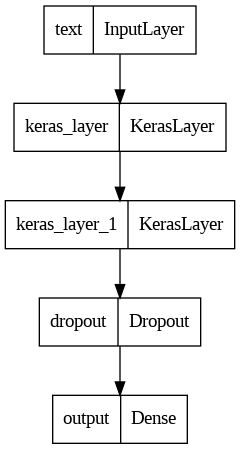

In [28]:
tf.keras.utils.plot_model(model)

### Fine tuning

Nous utilisons les valeurs de fine-tuning conseillées par la documentation pour un cas de jeu de données de taille moyenne :

- Nombre d'époques : 5
- Taille de lot (batch size) : 32
- Taux d'apprentissage (learning rate) : 3e-5 soit 0.00003

### Compilation

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [57]:
model.compile(optimizer = 'adam',
              loss = loss,
              metrics = [metrics])

## Entraînement du modèle

In [58]:
history = model.fit(train_batch,
                    epochs = 5,
                    validation_data = val_batch,
                    batch_size = 32)

# Temps d'entraînement : 45 minutes

Epoch 1/5
139/139 [==============================] - 563s 4s/step - loss: 0.2482 - binary_accuracy: 0.9028 - val_loss: 0.1526 - val_binary_accuracy: 0.9388
Epoch 2/5
139/139 [==============================] - 549s 4s/step - loss: 0.1359 - binary_accuracy: 0.9543 - val_loss: 0.1109 - val_binary_accuracy: 0.9694
Epoch 3/5
139/139 [==============================] - 507s 4s/step - loss: 0.1097 - binary_accuracy: 0.9658 - val_loss: 0.0988 - val_binary_accuracy: 0.9658
Epoch 4/5
139/139 [==============================] - 551s 4s/step - loss: 0.0974 - binary_accuracy: 0.9689 - val_loss: 0.0900 - val_binary_accuracy: 0.9685
Epoch 5/5
139/139 [==============================] - 554s 4s/step - loss: 0.0901 - binary_accuracy: 0.9719 - val_loss: 0.0859 - val_binary_accuracy: 0.9685


## Évaluation du modèle

### Visualisation

In [61]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


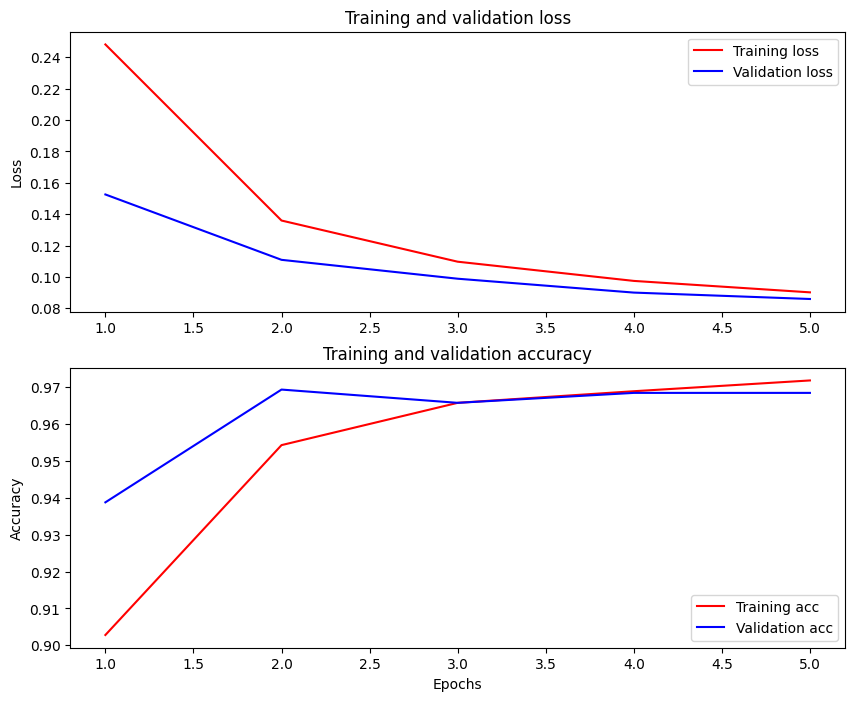

In [66]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Fonction pour récupérer toutes les métriques

In [97]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
    loss = log_loss(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1,
                          'loss': loss,}

    return model_results_dict

### Performance

In [68]:
model_results_train = evaluate_model(model, X_train, y_train)
model_results_train

139/139 [==============================] - 430s 3s/step


{'accuracy': 0.9754725472547254,
 'precision': 0.9267015706806283,
 'recall': 0.8879598662207357,
 'f1-score': 0.9069171648163962,
 'loss': 0.3910262147695958}

In [98]:
model_results = evaluate_model(model, X_val, y_val)
model_results

35/35 [==============================] - 98s 3s/step


{'accuracy': 0.9684968496849685,
 'precision': 0.9130434782608695,
 'recall': 0.8456375838926175,
 'f1-score': 0.8780487804878048,
 'loss': 0.5022354713050937}

### Matrice de confusion

In [74]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)
y_pred_binary = np.round(y_pred).astype(int)
conf_matrix = confusion_matrix(y_val, y_pred_binary)

print("Matrice de confusion :")
print(conf_matrix)

35/35 [==============================] - 105s 3s/step
Matrice de confusion :
[[950  12]
 [ 23 126]]


# Résultats

In [99]:
import pandas as pd

scores = pd.read_csv('model_scores.csv', sep=',')

bert_scores = pd.DataFrame([model_results])
bert_scores.insert(loc = 0,
            column = 'model',
            value = 'BERT')

In [100]:
all_metrics = pd.concat([bert_scores, scores])
all_metrics

,model,accuracy,precision,recall,f1-score,loss
0,BERT,0.968497,0.913043,0.845638,0.878049,0.502235
0,WE,0.986842,0.979381,0.913462,0.945274,0.209768
1,GRU,0.980263,0.910798,0.932692,0.921615,0.314652
2,LSTM,0.974282,0.883721,0.913462,0.898345,0.410002


Le modèle BERT ne nous permet pas d'avoir de meilleurs résultats qu'avec les modèles testés en Partie 2.

Nous obtenons un F1 score de 0.87 et une fonction de coût de 0.50, contre respectivement 0.94 et 0.20 avec le modèle Word Embedding simple.

De plus le temps d'entraînement est long avec BERT : 45 minutes, contre 13 secondes avec le modèle Word Embedding simple.